In [0]:
char_number = 30
img_size = 128
resume_iteration = 640    # 0 means training from scratch
google_drive_model_folder_path = '/content/gdrive/My Drive/2020 Spring/Material of Language/MOL Final/GlyphGAN Trained Models/Calligraphy/'

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import time

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, LeakyReLU, Flatten
from tensorflow.keras.layers import Dense, Conv2DTranspose, Reshape, Dropout
from tensorflow.keras.models import Sequential

import numpy as np
import matplotlib.pyplot as plt

In [0]:
data = np.load('fontarray_calligraphy.npy')
data = data/255.0
data = data.reshape(-1,char_number,img_size,img_size,1)
data = data.transpose(1,0,2,3,4)

In [7]:
data.shape

(30, 15, 128, 128, 1)

In [0]:
def make_generator():
  model = Sequential()
  model.add(Dense(8*8*512, input_dim = 128 + char_number))
  model.add(ReLU())
  
  model.add(Reshape((8,8,512)))
  model.add(Conv2DTranspose(512, (5, 5), strides=(2,2), padding='same'))
  model.add(ReLU())
            
  model.add(Conv2DTranspose(256, (5, 5), strides=(2,2), padding='same'))
  model.add(ReLU())
  
  model.add(Conv2DTranspose(128, (5, 5), strides=(2,2), padding='same'))
  model.add(ReLU())
  
  model.add(Conv2DTranspose(1, (5, 5), strides=(2,2), padding='same', activation='sigmoid'))
            
  return model

In [0]:
def make_discriminator():
  model = Sequential()
  model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(img_size,img_size,1)))
  model.add(LeakyReLU(alpha=0.2))
  
  model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  
  model.add(Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  
  model.add(Flatten())
  model.add(Dense(1))
  return model

In [0]:
@tf.function
def gen_fake_image(z):
    image_sample = generator(z)
    return tf.cast(image_sample, dtype = tf.dtypes.float32)

In [0]:
@tf.function
def cal_gradient_penalty(real_data, z):
  fake_data = gen_fake_image(z)

  alpha = tf.random.uniform(
        shape=[BATCH_SIZE,1], 
        minval=0.,
        maxval=1.
    )

  differences = fake_data - real_data
  interpolates = real_data + tf.reshape((alpha*tf.reshape(differences, (BATCH_SIZE,-1))), (BATCH_SIZE, img_size, img_size, 1))
  gradients = tf.gradients(discriminator(interpolates), [interpolates])[0]
  slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis = 1))
  gradient_penalty = tf.reduce_mean((slopes-1.)**2)
  return gradient_penalty

In [0]:
@tf.function
def cal_disc_cost(real_data, z, gradient_penalty):
  fake_data = gen_fake_image(z)
  return tf.reduce_mean(discriminator(fake_data)) - tf.reduce_mean(discriminator(real_data)) + LAMBDA*gradient_penalty

In [0]:
@tf.function
def make_one_hot(c, num, seed = None, num_char = char_number):
  return tf.concat([tf.reshape(tf.tile(tf.one_hot(c, num_char, dtype = tf.dtypes.float32), [num]), [-1, num_char]),
                    tf.random.normal(shape = (num,128), dtype = tf.dtypes.float32, seed = seed)], axis = 1)

In [0]:
@tf.function
def make_consist(num_char = char_number):
  z = tf.tile(tf.random.normal(shape = (1,128), dtype = tf.dtypes.float32), [num_char,1])
  letter_one_hot = tf.reshape(tf.one_hot(0, num_char, dtype = tf.dtypes.float32), [1,-1])
  for c in range(1, num_char):
    temp = tf.reshape(tf.one_hot(c, num_char, dtype = tf.dtypes.float32), [1, -1])
    letter_one_hot = tf.concat([letter_one_hot, temp], axis = 0)
  return tf.concat([letter_one_hot,z], axis = 1)

In [0]:
def update_disc(batch_data, c):
  real_data = tf.cast(batch_data, dtype = tf.float32)
  tf.random.set_seed(None)
  z = make_one_hot(c, BATCH_SIZE)

  with tf.GradientTape() as tape:
    gradient_penalty = cal_gradient_penalty(real_data, z)
    disc_cost = cal_disc_cost(real_data, z, gradient_penalty)
  disc_gradient = tape.gradient(disc_cost, discriminator.trainable_variables)
  disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
  return disc_cost

In [0]:
def update_gen(c):
    tf.random.set_seed(None)
    z = make_one_hot(c, BATCH_SIZE)
    with tf.GradientTape() as tape:
      fake_data = gen_fake_image(z)
      gen_cost = -tf.reduce_mean(discriminator(fake_data))
    gen_gradient = tape.gradient(gen_cost, generator.trainable_variables)
    gen_opt.apply_gradients(zip(gen_gradient, generator.trainable_variables))
    return gen_cost

In [0]:
def plot_image(iteration, numchar = char_number):
    z = make_consist(num_char = numchar)
    fig = plt.figure(figsize=(9,6))
    image_sample = gen_fake_image(z)
    image_sample = image_sample.numpy().reshape(-1,img_size,img_size,1)
    for i in range(image_sample.shape[0]):
      plt.subplot(9, 6, i+1)
      plt.axis('off')
      plt.imshow(image_sample[i, :, :, 0], cmap = 'gray')
      plt.savefig('save_img/iteration{}.png'.format(iteration))
    plt.show()
    plt.close()
    
   
def plot_loss(disc_cost_epoch, gen_cost_epoch):
  fig, axes = plt.subplots(1,2, figsize = (16,4))
  axes[0].plot(disc_cost_epoch, label = 'discriminator loss', color = 'orange')
  axes[0].legend()
  
  axes[1].plot(gen_cost_epoch, label = 'generator loss', color = 'blue')
  axes[1].legend()
  plt.show()
  plt.clf()


def plot_same(z_fix, iteration):
    fig = plt.figure(figsize=(9,6))
    image_sample = gen_fake_image(z_fix)
    image_sample = image_sample.numpy().reshape(-1,img_size,img_size,1)
    for i in range(image_sample.shape[0]):
      plt.subplot(9, 6, i+1)
      plt.axis('off')
      plt.imshow(image_sample[i, :, :, 0], cmap = 'gray')
      plt.savefig('save_img_fix/iteration{}.png'.format(iteration))
    plt.show()
    plt.close()

In [0]:
disc_opt = tf.keras.optimizers.Adam(
        learning_rate=1e-4,
        beta_1=0.5, 
        beta_2=0.99)

gen_opt = tf.keras.optimizers.Adam(
        learning_rate=1e-4,
        beta_1=0.5, 
        beta_2=0.99)

In [0]:
z_fix = make_consist(num_char = char_number)
np.save('z_fix.npy', z_fix.numpy())

z_fix = tf.constant(np.load('z_fix.npy'))

In [0]:
generator = make_generator()
discriminator = make_discriminator()

In [0]:
!mkdir checkpoint_gen
!mkdir checkpoint_disc
!mkdir save_img_fix
!mkdir save_img

In [0]:
if resume_iteration > 0:
  generator.load_weights('{}cp_gen_{}th_epoch.h5'.format(google_drive_model_folder_path, resume_iteration))
  discriminator.load_weights('{}cp_disc_{}_th_epoch.h5'.format(google_drive_model_folder_path, resume_iteration))

finish epoch:640 --- time use this epoch:62.864962100982666


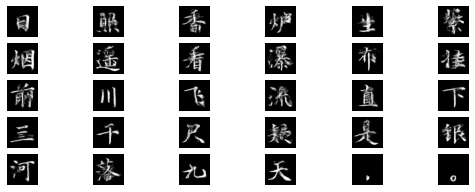

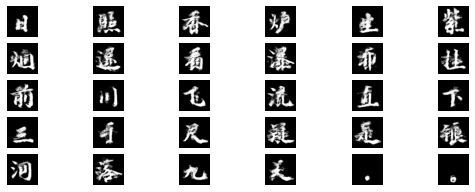

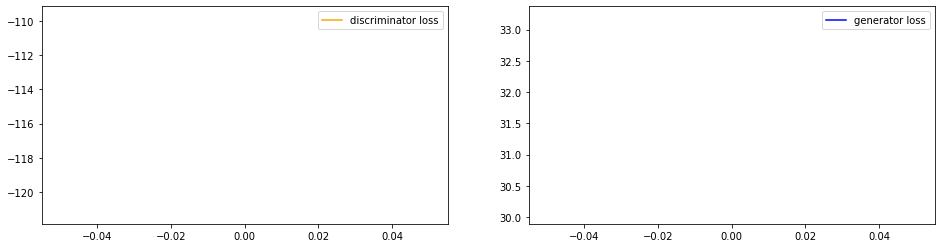

finish epoch:641 --- time use this epoch:55.456058979034424
finish epoch:642 --- time use this epoch:55.08904814720154
finish epoch:643 --- time use this epoch:54.99778127670288
finish epoch:644 --- time use this epoch:55.631601333618164
finish epoch:645 --- time use this epoch:55.107035875320435
finish epoch:646 --- time use this epoch:55.11158895492554
finish epoch:647 --- time use this epoch:55.212244510650635
finish epoch:648 --- time use this epoch:55.188705921173096
finish epoch:649 --- time use this epoch:55.211204528808594
finish epoch:650 --- time use this epoch:55.616230487823486


<Figure size 432x288 with 0 Axes>

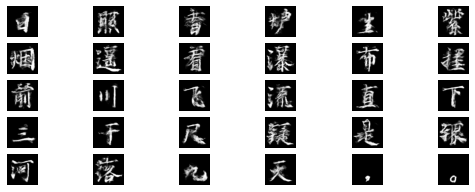

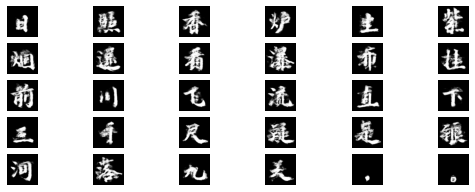

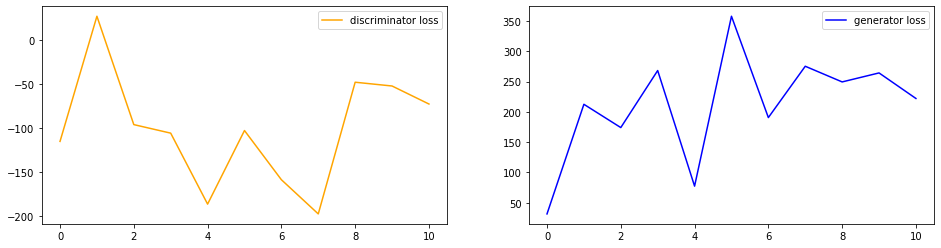

finish epoch:651 --- time use this epoch:57.52269124984741
finish epoch:652 --- time use this epoch:56.34582281112671
finish epoch:653 --- time use this epoch:56.04432249069214
finish epoch:654 --- time use this epoch:56.36110472679138
finish epoch:655 --- time use this epoch:56.662837505340576
finish epoch:656 --- time use this epoch:56.06167793273926
finish epoch:657 --- time use this epoch:56.23275685310364
finish epoch:658 --- time use this epoch:56.32714557647705
finish epoch:659 --- time use this epoch:56.43756461143494
finish epoch:660 --- time use this epoch:56.24835705757141


<Figure size 432x288 with 0 Axes>

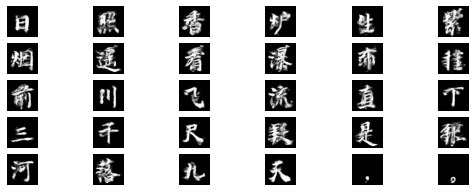

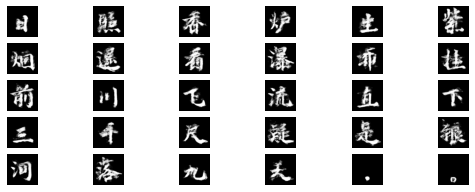

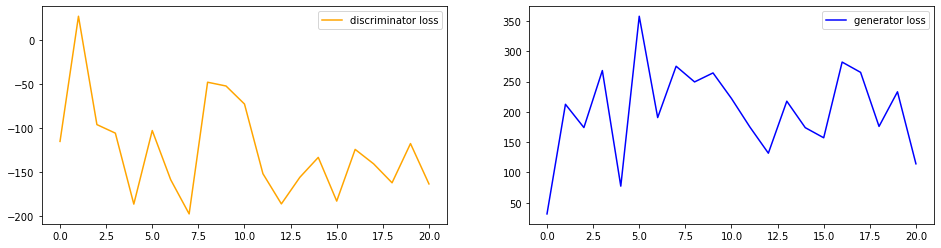

finish epoch:661 --- time use this epoch:56.80947399139404
finish epoch:662 --- time use this epoch:59.138548135757446
finish epoch:663 --- time use this epoch:60.01113224029541
finish epoch:664 --- time use this epoch:61.10541892051697
finish epoch:665 --- time use this epoch:58.3442280292511
finish epoch:666 --- time use this epoch:58.02480912208557
finish epoch:667 --- time use this epoch:57.25484609603882
finish epoch:668 --- time use this epoch:57.198883056640625
finish epoch:669 --- time use this epoch:57.417014598846436
finish epoch:670 --- time use this epoch:57.430405616760254


<Figure size 432x288 with 0 Axes>

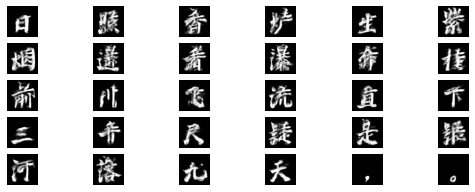

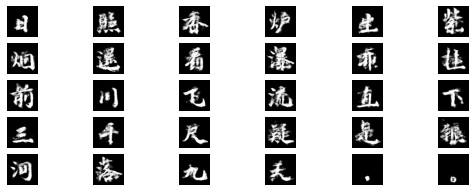

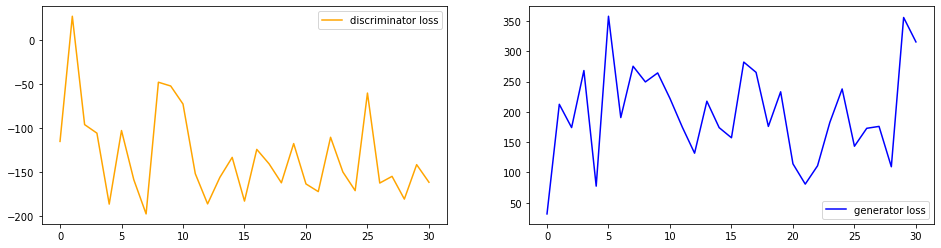

finish epoch:671 --- time use this epoch:58.04341959953308
finish epoch:672 --- time use this epoch:57.441930055618286
finish epoch:673 --- time use this epoch:57.58576154708862
finish epoch:674 --- time use this epoch:57.61881494522095
finish epoch:675 --- time use this epoch:57.743151903152466
finish epoch:676 --- time use this epoch:57.72958779335022
finish epoch:677 --- time use this epoch:57.26800560951233
finish epoch:678 --- time use this epoch:57.459521532058716
finish epoch:679 --- time use this epoch:57.441362380981445
finish epoch:680 --- time use this epoch:57.10588598251343


<Figure size 432x288 with 0 Axes>

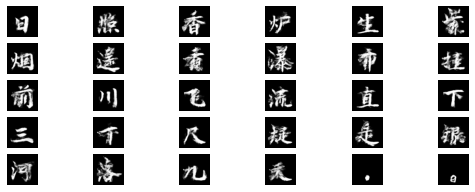

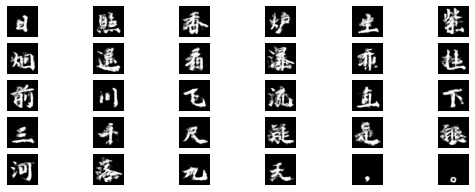

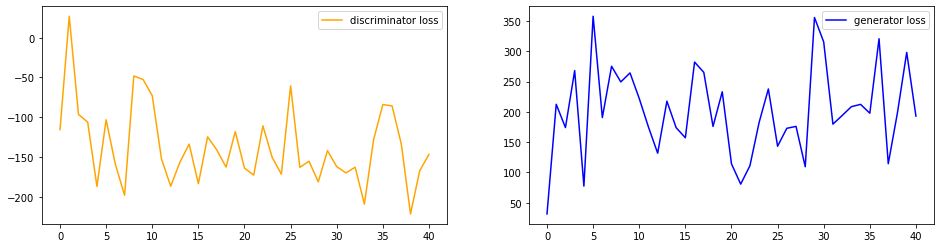

finish epoch:681 --- time use this epoch:58.4536828994751
finish epoch:682 --- time use this epoch:57.27882957458496
finish epoch:683 --- time use this epoch:56.97780442237854
finish epoch:684 --- time use this epoch:57.0131413936615
finish epoch:685 --- time use this epoch:57.33914375305176
finish epoch:686 --- time use this epoch:57.277127742767334
finish epoch:687 --- time use this epoch:57.663323640823364
finish epoch:688 --- time use this epoch:57.35998225212097
finish epoch:689 --- time use this epoch:57.33165240287781
finish epoch:690 --- time use this epoch:57.63606071472168


<Figure size 432x288 with 0 Axes>

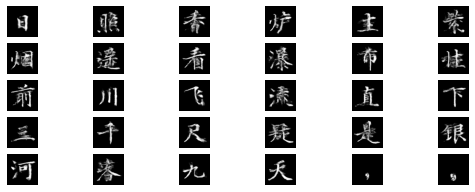

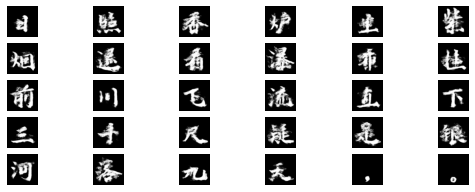

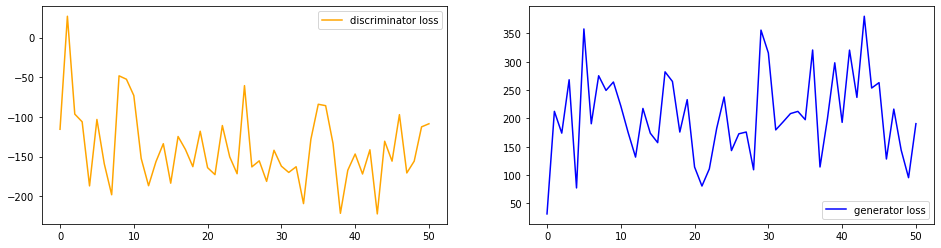

finish epoch:691 --- time use this epoch:58.35254693031311
finish epoch:692 --- time use this epoch:59.610432863235474
finish epoch:693 --- time use this epoch:59.70924782752991
finish epoch:694 --- time use this epoch:59.492555141448975
finish epoch:695 --- time use this epoch:58.76476311683655
finish epoch:696 --- time use this epoch:58.64978337287903
finish epoch:697 --- time use this epoch:58.02047514915466
finish epoch:698 --- time use this epoch:57.91005516052246
finish epoch:699 --- time use this epoch:57.56738591194153
finish epoch:700 --- time use this epoch:57.327096700668335


<Figure size 432x288 with 0 Axes>

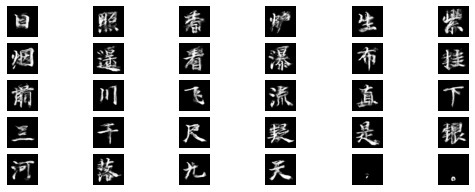

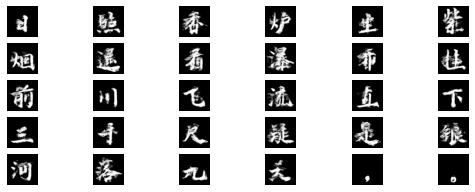

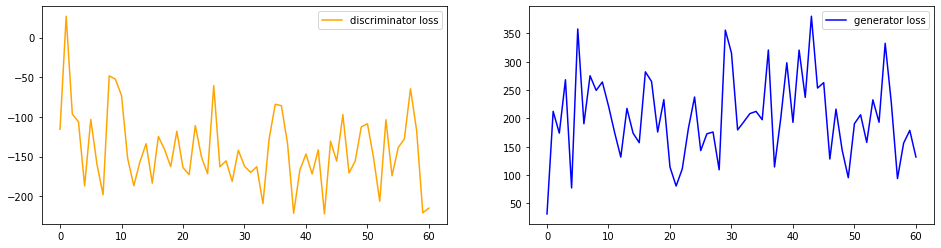

finish epoch:701 --- time use this epoch:57.81044340133667
finish epoch:702 --- time use this epoch:57.494499921798706
finish epoch:703 --- time use this epoch:57.924392223358154
finish epoch:704 --- time use this epoch:57.55329394340515
finish epoch:705 --- time use this epoch:57.31185793876648
finish epoch:706 --- time use this epoch:57.54017519950867
finish epoch:707 --- time use this epoch:57.57494878768921
finish epoch:708 --- time use this epoch:57.69059443473816
finish epoch:709 --- time use this epoch:57.414156913757324
finish epoch:710 --- time use this epoch:57.39327955245972


<Figure size 432x288 with 0 Axes>

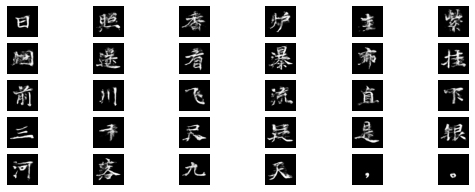

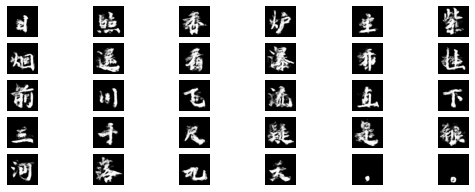

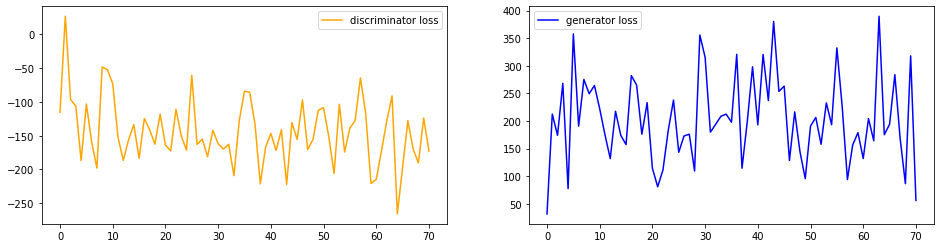

finish epoch:711 --- time use this epoch:57.63031768798828
finish epoch:712 --- time use this epoch:57.24245357513428
finish epoch:713 --- time use this epoch:57.50903367996216
finish epoch:714 --- time use this epoch:58.40304517745972
finish epoch:715 --- time use this epoch:57.45517086982727
finish epoch:716 --- time use this epoch:56.873310565948486
finish epoch:717 --- time use this epoch:56.38039708137512
finish epoch:718 --- time use this epoch:57.217034339904785
finish epoch:719 --- time use this epoch:57.1543493270874
finish epoch:720 --- time use this epoch:56.7963764667511


<Figure size 432x288 with 0 Axes>

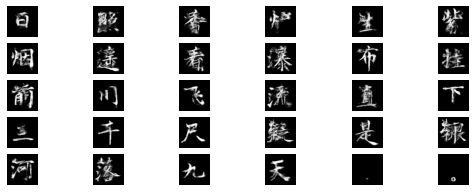

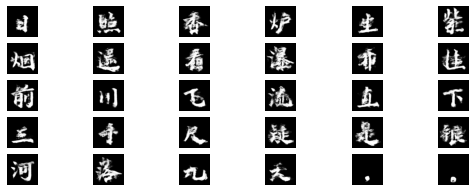

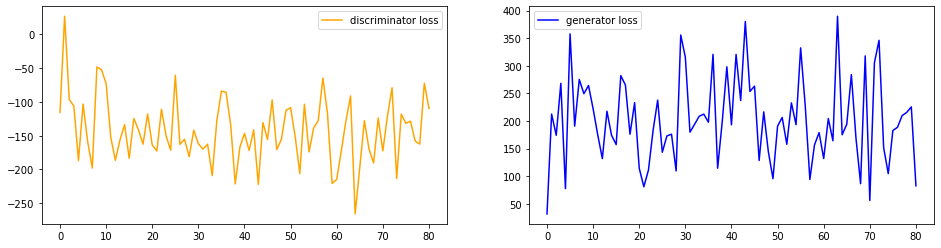

finish epoch:721 --- time use this epoch:57.51950240135193
finish epoch:722 --- time use this epoch:56.524038791656494
finish epoch:723 --- time use this epoch:56.71935558319092
finish epoch:724 --- time use this epoch:57.05264449119568
finish epoch:725 --- time use this epoch:56.9290611743927
finish epoch:726 --- time use this epoch:56.56908988952637
finish epoch:727 --- time use this epoch:56.657408475875854
finish epoch:728 --- time use this epoch:57.07667303085327
finish epoch:729 --- time use this epoch:56.775983572006226
finish epoch:730 --- time use this epoch:57.046369791030884


<Figure size 432x288 with 0 Axes>

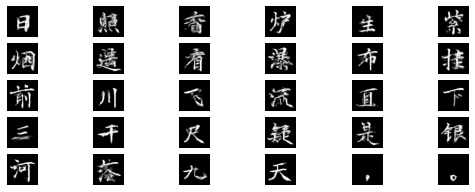

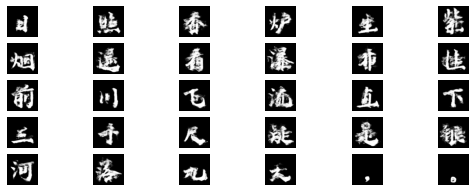

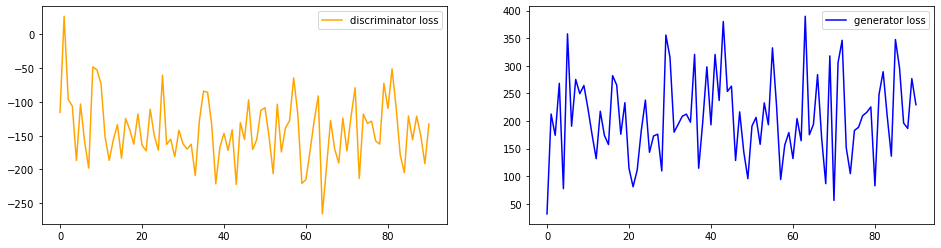

finish epoch:731 --- time use this epoch:57.48124051094055
finish epoch:732 --- time use this epoch:56.73122310638428
finish epoch:733 --- time use this epoch:57.00170159339905
finish epoch:734 --- time use this epoch:57.23158860206604
finish epoch:735 --- time use this epoch:57.4670786857605
finish epoch:736 --- time use this epoch:57.20453858375549
finish epoch:737 --- time use this epoch:56.91303610801697
finish epoch:738 --- time use this epoch:57.105947971343994
finish epoch:739 --- time use this epoch:57.26622486114502
finish epoch:740 --- time use this epoch:57.311275243759155


<Figure size 432x288 with 0 Axes>

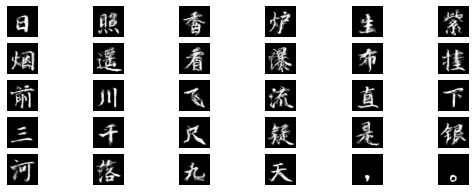

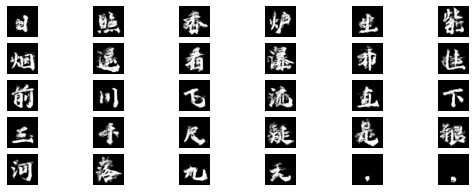

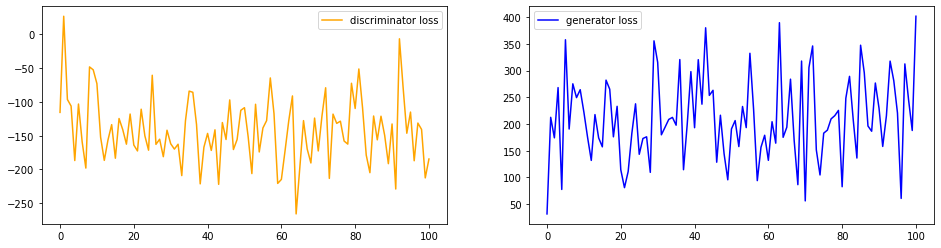

finish epoch:741 --- time use this epoch:58.41848874092102
finish epoch:742 --- time use this epoch:57.92470860481262
finish epoch:743 --- time use this epoch:57.87194538116455
finish epoch:744 --- time use this epoch:59.14685249328613
finish epoch:745 --- time use this epoch:60.39089608192444
finish epoch:746 --- time use this epoch:59.22133994102478
finish epoch:747 --- time use this epoch:59.04159927368164
finish epoch:748 --- time use this epoch:58.86283612251282


In [0]:
#train on font array dataset

BATCH_SIZE = 10 # Batch size
CRITIC_ITERS = 5 # For WGAN and WGAN-GP, number of critic iters per gen iter
LAMBDA = 10 # Gradient penalty lambda hyperparameter
ITERS = 2500 # How many generator iterations to train for 
# OUTPUT_DIM = (128,128,1) # Number of pixels 
sample_interval = 10

gen_cost_epoch = []
disc_cost_epoch = []

for iteration in range(resume_iteration, ITERS):
    start = time.time()
    for c in range(char_number):
      data_iter = tf.data.Dataset.from_tensor_slices(data[c]).shuffle(buffer_size = 100).batch(BATCH_SIZE, drop_remainder=True).repeat()
      data_batch = iter(data_iter)
      gen_cost_c = []
      for i in range(CRITIC_ITERS):
        disc_cost_batch = []
        disc_cost_batch.append(update_disc(next(data_batch),c).numpy())
        # print('finish update c of char:{}, epoch:{}'.format(c, iteration))
      gen_cost_c.append(update_gen(c).numpy())
#       print('finish update gen of char:{}, epoch:{}'.format(c, iteration))
    gen_cost_epoch.append(np.mean(gen_cost_c))
    disc_cost_epoch.append(tf.reduce_mean(disc_cost_batch))
    print('finish epoch:{} --- time use this epoch:{}'.format(iteration, time.time() - start))
    if iteration % sample_interval == 0:
        generator.save('checkpoint_gen/cp_gen_{}th_epoch.h5'.format(iteration))
        discriminator.save('checkpoint_disc/cp_disc_{}_th_epoch.h5'.format(iteration))
        generator.save('{}cp_gen_{}th_epoch.h5'.format(google_drive_model_folder_path, iteration))
        discriminator.save('{}cp_disc_{}_th_epoch.h5'.format(google_drive_model_folder_path, iteration))
        plot_image(iteration)
        plot_same(z_fix, iteration)
        plot_loss(disc_cost_epoch, gen_cost_epoch)